In [1]:
from IPython.display import HTML

style = """
<style>
#header, div.unselected { display: none !important }
#notebook, .container { padding: 1 !important }
#site { height: 100% !important }
</style>
"""
style = "" # Comment to turn on

HTML(style)

In [2]:
import requests
from bs4 import BeautifulSoup
import time
import pandas as pd
import json
import random as rd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn import set_config
set_config(display='diagram')
%matplotlib inline
import matplotlib.pyplot as plt

# Thu thập dữ liệu
Dữ liệu được thu thập từ trang myanimelist thông qua api từ jikan.moe.
Do việc thu thập dữ liệu rất lâu(Khoảng gần 2h) nên bộ dữ liệu 'anime_rating_table' đã được chuẩn bị chung. Khi cần chạy thử hàm thu thập dữ liệu thì hãy chuyển điểm break 'collect_info' thành giá trị True. Hàm được setup bỏ qua để có thể chạy Kernel - Restart & Run All mà không mất nhiều thời gian

In [3]:
def colect_multichoice(collect, json_text):
    target = ''
    for i in range(10):
        try:
            target = target + json_text[f'{collect}'][i]['name'] + ','
        except IndexError:
            break
    target = target[:-1]
    return target

In [4]:
def collect_infor_anime(anime_file, sleep_time):
    title = 'title'
    source = 'source'
    episodes = 'episodes'
    duration = 'duration'
    rating = 'rating'
    score = 'score'
    scored_by = 'scored_by'
    producers = 'producers'
    studios = 'studios'
    genres = 'genres'
    favorites = 'favorites'
    f = open(anime_file, 'w', encoding='utf-8')
    f.write(f'{title}\t{genres}\t{rating}\t{source}\t{episodes}\t{duration}\t{producers}\t{studios}\t{favorites}\t{score}\t{scored_by}\n')
    key = rd.randint(1,40)
    while True:
        producers = 'producers'
        studios = 'studios'
        genres = 'genres'
        try:
            url_run = f'https://api.jikan.moe/v3/anime/{key}'
            json_url=requests.get(url_run)
            json_text = json_url.json()
            while True:
                if(json_text['status'] != 404): break
                else:
                    key += rd.randint(1,15)
                    url_run = f'https://api.jikan.moe/v3/anime/{key}'
                    json_url=requests.get(url_run)
                    json_text = json_url.json()
            title = json_text['title']
            source = json_text['source']
            episodes = json_text['episodes']
            duration = json_text['duration']
            rating = json_text['rating']
            score = json_text['score']
            scored_by = json_text['scored_by']
            favorites = json_text['favorites']
            producers = colect_multichoice(producers, json_text)
            studios = colect_multichoice(studios, json_text)
            genres = colect_multichoice(genres, json_text)
        except KeyError:
            key += rd.randint(1,15)
            continue
        else:
            f.write(f'{title}\t{genres}\t{rating}\t{source}\t{episodes}\t{duration}\t{producers}\t{studios}\t{favorites}\t{score}\t{scored_by}\n')
            key += rd.randint(1,15)
            if (key >= 30000): break 
            time.sleep(sleep_time)
    f.close()
collect_info = False
if (collect_info == True):
    collect_infor_anime('anime_rating_table', sleep_time = 4)

# Tiền xử lý lần 1
Xem dữ liệu vừa thu thập được, đánh giá chúng để chuẩn bị cho bước tiền xử lý dữ liệu và tiền xử lý tập dữ liệu thu thập được

In [5]:
df = pd.read_csv('anime_rating_table',sep = '\t')
df

,title,genres,rating,source,episodes,duration,producers,studios,favorites,score,scored_by
0,Bouken Ou Beet,"Adventure,Fantasy,Shounen,Supernatural",PG - Children,Manga,52,23 min per ep,"TV Tokyo,Dentsu",Toei Animation,18,6.98,5324
1,Hungry Heart: Wild Striker,"Slice of Life,Comedy,Sports,Shounen",PG-13 - Teens 13 or older,Manga,52,23 min per ep,NaN,Nippon Animation,229,7.59,10620
2,Monster,"Drama,Horror,Mystery,Police,Psychological,Sein...",R+ - Mild Nudity,Manga,74,24 min per ep,"VAP,Shogakukan-Shueisha Productions,Nippon Tel...",Madhouse,28045,8.75,188661
3,One Piece,"Action,Adventure,Comedy,Super Power,Drama,Fant...",PG-13 - Teens 13 or older,Manga,None,24 min,"Fuji TV,TAP,Shueisha",Toei Animation,115607,8.5,696184
4,Texhnolyze,"Action,Sci-Fi,Psychological,Drama",R+ - Mild Nudity,Original,22,23 min per ep,"Group TAC,Rondo Robe,Fuji TV,Pioneer LDC",Madhouse,3595,7.76,39927
...,...,...,...,...,...,...,...,...,...,...,...
1236,Fukusuke,NaN,G - All Ages,Original,1,18 min,NaN,NaN,1,5.6,183
1237,Goman-hiki,Kids,G - All Ages,Unknown,100,3 min per ep,Otogi Production,NaN,0,None,None
1238,Tsuru no Ongaeshi,Kids,G - All Ages,Original,1,17 min,Gakken Eigakyoku,NaN,0,None,None
1239,Swimming,Dementia,G - All Ages,Unknown,1,4 min,NaN,NaN,0,5.44,125


In [6]:
def convert_dtypes(col):
    if (col.name in ['score','scored_by','episodes']):
        return pd.to_numeric(col, errors='coerce')
    elif col.name in 'duration':
        h_col = col.str.extract(r'(\d+) hr', expand=False)
        h_col = pd.to_numeric(h_col.fillna(0))
        m_col = col.str.extract(r'(\d+) min', expand=False)
        m_col = pd.to_numeric(m_col.fillna(0))
        return h_col * 60 + m_col
    return col
temp = df.apply(convert_dtypes)
df = temp

In [7]:
df.dropna(subset = ['score'], inplace = True)
df.set_index('title', inplace = True)
df

,genres,rating,source,episodes,duration,producers,studios,favorites,score,scored_by
title,,,,,,,,,,
Bouken Ou Beet,"Adventure,Fantasy,Shounen,Supernatural",PG - Children,Manga,52.0,23,"TV Tokyo,Dentsu",Toei Animation,18,6.98,5324.0
Hungry Heart: Wild Striker,"Slice of Life,Comedy,Sports,Shounen",PG-13 - Teens 13 or older,Manga,52.0,23,NaN,Nippon Animation,229,7.59,10620.0
Monster,"Drama,Horror,Mystery,Police,Psychological,Sein...",R+ - Mild Nudity,Manga,74.0,24,"VAP,Shogakukan-Shueisha Productions,Nippon Tel...",Madhouse,28045,8.75,188661.0
One Piece,"Action,Adventure,Comedy,Super Power,Drama,Fant...",PG-13 - Teens 13 or older,Manga,NaN,24,"Fuji TV,TAP,Shueisha",Toei Animation,115607,8.50,696184.0
Texhnolyze,"Action,Sci-Fi,Psychological,Drama",R+ - Mild Nudity,Original,22.0,23,"Group TAC,Rondo Robe,Fuji TV,Pioneer LDC",Madhouse,3595,7.76,39927.0
...,...,...,...,...,...,...,...,...,...,...
Aria the Avvenire,"Sci-Fi,Slice of Life,Fantasy,Shounen",G - All Ages,Manga,3.0,21,Shochiku,TYO Animations,94,7.95,7614.0
Yellow,Psychological,G - All Ages,Original,1.0,9,NaN,NaN,1,5.14,201.0
Fukusuke,NaN,G - All Ages,Original,1.0,18,NaN,NaN,1,5.60,183.0


# Khám phá dữ liệu 
chia các tập dữ liệu thành train, test, validation và khám phá các dữ liệu để tiền xử lý

In [8]:
#Chia tap train, validation va test
y = df['score']
X = df.drop('score',axis = 1)
X_df, X_test, y_df, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_df, y_df, test_size=0.2)

In [9]:
#Thong ke nhung cot mang gia tri so
num_cols = ['episodes', 'duration', 'scored_by','favorites']
df = X_train[num_cols]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)
df.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max'])

,episodes,duration,scored_by,favorites
missing_ratio,0.5,0.0,0.0,0.0
min,1.0,0.0,104.0,0.0
lower_quartile,1.0,18.0,572.0,2.0
median,2.0,24.0,1951.0,10.0
upper_quartile,12.0,30.0,10717.0,65.0
max,510.0,140.0,1279878.0,173446.0


In [10]:
#Thong ke nhung cot mang gia tri chu
pd.set_option('display.max_colwidth', 200)
cat_cols = list(set(X_train.columns) - set(num_cols))
df = X_train[cat_cols]
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def num_values(df):
    return df.nunique()
def value_ratios(c):
    return dict((c.value_counts(normalize=True) * 100).round(1))
df.agg([missing_ratio, num_values, value_ratios])

,genres,producers,source,studios,rating
missing_ratio,0.1,32.5,0,29.2,0
num_values,564,350,15,144,7
value_ratios,"{'Hentai': 10.0, 'Comedy': 2.4, 'Music': 1.3, 'Dementia': 0.9, 'Music,Kids': 0.9, 'Fantasy': 0.9, 'Slice of Life,Comedy': 0.7, 'Slice of Life': 0.5, 'Adventure,Sci-Fi': 0.5, 'Comedy,Slice of Life'...","{'Pink Pineapple': 4.7, 'NHK': 2.9, 'Bandai Visual': 2.1, 'TV Asahi': 1.4, 'NuTech Digital': 1.2, 'Digital Works,Y.O.U.C': 1.2, 'Lantis': 1.2, 'Aniplex': 1.0, 'Shueisha': 1.0, 'Starchild Records':...","{'Manga': 25.6, 'Unknown': 24.3, 'Original': 23.0, 'Visual novel': 9.5, 'Light novel': 4.7, 'Game': 4.5, 'Novel': 3.4, '4-koma manga': 1.6, 'Other': 1.4, 'Music': 0.9, 'Book': 0.4, 'Picture book':...","{'Toei Animation': 9.1, 'Sunrise': 8.0, 'Madhouse': 6.3, 'Studio Deen': 5.2, 'J.C.Staff': 3.5, 'Production I.G': 3.5, 'TMS Entertainment': 3.0, 'Studio Pierrot': 2.8, 'OLM': 2.4, 'Bones': 2.2, 'Ni...","{'PG-13 - Teens 13 or older': 38.2, 'G - All Ages': 19.8, 'Rx - Hentai': 14.7, 'R - 17+ (violence & profanity)': 11.0, 'R+ - Mild Nudity': 8.1, 'PG - Children': 7.5, 'None': 0.5}"


# Tiền xử lý lần 2
Xử lý các dữ liệu và tạo tập pipeline để huấn luyện

In [11]:
#Xu ly drop nhung cot khong can thiet
class colDrop(BaseEstimator, TransformerMixin):
    def __init__(self):
        return
    def fit(self, X_df, y = None):
        return self
    def transform(self, X_df, y = None):
        temp_df = X_df.copy()
        temp_df.genres.fillna('Others', inplace = True)
        temp_df.drop(columns=['producers','studios'], axis = 1, inplace = True) #Qua nhieu gia tri thieu
        temp_df.drop(columns=['favorites','scored_by'], axis = 1, inplace = True) #Phim moi chua co nhieu thong tin nguoi thich va danh gia
        return temp_df

In [12]:
class customOneHotEncoder_1(BaseEstimator, TransformerMixin):
    def __init__(self, num_top_ = 1):
        self.num_top_ = num_top_
    def fit(self,X_df,y=None):
        return self
    def transform(self,X_df,y=None):
        #Tao ra mot bang moi chua cac gia tri sau khi OHE va ten cot la ten gia tri cua chung, xu ly cot multiplechoice
        df = X_df.copy()
        df_1 = df.genres.str.split(',').explode()
        genres_counts_ = df_1.value_counts()
        genres = list(genres_counts_.index)
        top_genres_ = genres[:max(1, min(self.num_top_, len(genres)))]
        top_tier_genres_ = 'top_' + f'{self.num_top_}' + '_genres'
        name_genres = [top_tier_genres_ ,'Others_genres']
        df = df.reindex(df.columns.tolist() + name_genres, axis=1, fill_value=0)
        for index in df.index:
            for val in df.loc[index,'genres'].split(','):
                if(val in top_genres_):
                    df.loc[index,top_tier_genres_] += 1
                else:
                    df.loc[index,'Others_genres'] += 1
        df.drop('genres', axis = 1, inplace = True)
        return df

In [13]:
class customOneHotEncoder_2(BaseEstimator, TransformerMixin):
    def __init__(self, num_top_rating_ = 1, num_top_source_ = 1):
        self.num_top_rating_ = num_top_rating_
        self.num_top_source_ = num_top_source_
    def fit(self,X_df,y=None):
        return self
    def transform(self,X_df,y=None):
        #Tao ra mot bang moi chua cac gia tri sau khi OHE va ten cot la ten gia tri cua chung, xu ly cot onechoice
        df = X_df.copy()
        df_1 = df.rating
        df_2 = df.source
        #Xu ly cot ratings
        rating_counts_ = df_1.value_counts()
        rating = list(rating_counts_.index)
        top_rating_ = rating[:max(0, min(self.num_top_rating_, len(rating)))]
        top_tier_rating_ = 'top_' + f'{self.num_top_rating_}' + '_ratings'
        name_rating = [top_tier_rating_ ,'Others_ratings']
        df = df.reindex(df.columns.tolist() + name_rating, axis=1, fill_value=0)
        for index in df.index:
            if(df.loc[index,'rating'] in top_rating_):
                df.loc[index,top_tier_rating_] = 1
            else:
                df.loc[index,'Others_ratings'] = 1
        #Xu ly cot sources
        source_counts_ = df_2.value_counts()
        source = list(source_counts_.index)
        top_source_ = source[:max(1, min(self.num_top_source_, len(source)))]
        top_tier_source_ = 'top_' + f'{self.num_top_source_}' + '_source'
        name_source = [top_tier_source_ ,'Others_sources']
        df = df.reindex(df.columns.tolist() + name_source, axis=1, fill_value=0)
        for index in df.index:
            if(df.loc[index,'source'] in top_source_):
                df.loc[index,top_tier_source_] = 1
            else:
                df.loc[index,'Others_sources'] = 1
        df.drop(['rating','source'], axis = 1, inplace = True)
        return df

In [14]:
pipeline_col = Pipeline(steps = [
    ('drop1',colDrop()),
    ('cohe1', customOneHotEncoder_1(num_top_ = 2)),
    ('cohe2',customOneHotEncoder_2(num_top_rating_ = 2, num_top_source_ = 2))
])
col_trans = ColumnTransformer(transformers=[
    ('trans', pipeline_col, X_train.columns)
])
pipeline_prep = Pipeline(steps = [
    ('col_trans', col_trans),
    ('imputer', SimpleImputer()),
])
full_pipeline = Pipeline(steps = [
    ('prep',pipeline_prep),
    ('lnr', LinearRegression()),
])
full_pipeline

Pipeline(steps=[('prep',
                 Pipeline(steps=[('col_trans',
                                  ColumnTransformer(transformers=[('trans',
                                                                   Pipeline(steps=[('drop1',
                                                                                    colDrop()),
                                                                                   ('cohe1',
                                                                                    customOneHotEncoder_1(num_top_=2)),
                                                                                   ('cohe2',
                                                                                    customOneHotEncoder_2(num_top_rating_=2,
                                                                                                          num_top_source_=2))]),
                                                                   Index(['genres', 'rating', 'source', 'episodes', 'duration', 'producers',
       'studios', 'favorites', 'scored_by'],
      dtype='object'))])),
                                 ('imputer', SimpleImputer())])),
                ('lnr', LinearRegression())])

# Huấn luyện mô hình
Huấn luyện tập dữ liệu bằng mô hình Linear Regression

In [15]:
def TrainingData(best_val_rr, best_top_, best_top_rating_, best_top_source_, train_rr, val_rr, top_, top_rating_, top_source_):
    for num_top_ in top_:
        for num_top_rating_ in top_rating_: 
            for num_top_source_ in top_source_:
                full_pipeline.set_params(prep__col_trans__trans__cohe1__num_top_ = num_top_, 
                                         prep__col_trans__trans__cohe2__num_top_rating_ = num_top_rating_, prep__col_trans__trans__cohe2__num_top_source_ = num_top_source_)
                full_pipeline.fit(X_train, y_train)
                train_rr.append(full_pipeline.score(X_train,y_train))
                val_rr.append(full_pipeline.score(X_val,y_val))
                if(full_pipeline.score(X_val,y_val) >= max(val_rr)):
                    best_top_ = num_top_
                    best_top_rating_ = num_top_rating_
                    best_top_source_ = num_top_source_
    best_val_rr = max(val_rr)
    f = open('best model', 'w', encoding = 'utf-8')
    f.write(f'{best_val_rr}\n{best_top_}\n{best_top_rating_}\n{best_top_source_}\n{train_rr}\n{val_rr}\n{top_}\n{top_rating_}\n{top_source_}')
    f.close()

Do thời gian để máy học khá là dài nên bọn em đã lưu mô hình tốt nhất ở file 'best model'. Khi cần máy học thì chuyển điểm break 'Training_Again' thành True

In [16]:
Training_Again = False
if(Training_Again == True):
    best_val_rr = float('inf'); best_top_ = None; best_top_rating_ = None; best_top_source_ = None
    train_rr =[]
    val_rr = []
    top_ = [3, 5, 7, 9, 11, 13, 15, 17]
    top_rating_ = [1, 2, 3, 4, 5]
    top_source_ = [1, 2, 3, 4, 5]
    TrainingData(best_val_rr, best_top_, best_top_rating_, best_top_source_, train_rr, val_rr, top_, top_rating_, top_source_)
#Doc file va chuyen cac thong tin trong file thanh cac du lieu can thiet
f = open('best model', 'r', encoding = 'utf-8')
best_val_rr = float(f.readline())
best_top_ = int(f.readline())
best_top_rating_ = int(f.readline())
best_top_source_ = int(f.readline())
train_rr = f.readline().rstrip()[1:-1].split(',')
train_rr = [float(numeric_string) for numeric_string in train_rr]
val_rr = f.readline().rstrip()[1:-1].split(',')
val_rr = [float(numeric_string) for numeric_string in val_rr]
top_ = f.readline().rstrip()[1:-1].split(',')
top_ = [int(numeric_string) for numeric_string in top_]
top_rating_ = f.readline().rstrip()[1:-1].split(',')
top_rating_ = [int(numeric_string) for numeric_string in top_rating_]
top_source_ = f.readline().rstrip()[1:-1].split(',')
top_source_ = [int(numeric_string) for numeric_string in top_source_]
f.close()

In [17]:
print(f'Độ đo rr tốt nhất trên tập validation là: {best_val_rr}')
print(f'Top genres tốt nhất là: {best_top_}')
print(f'Top rating tốt nhất là: {best_top_rating_}')
print(f'Top source tốt nhất là: {best_top_source_}')

Độ đo rr tốt nhất trên tập validation là: 0.2800049613746428
Top genres tốt nhất là: 17
Top rating tốt nhất là: 1
Top source tốt nhất là: 3


In [18]:
def compute_mse(y, preds):
    return ((y - preds) ** 2).mean()
def compute_rr(y, preds, baseline_preds):
    return 1 - compute_mse(y, preds) / compute_mse(y, baseline_preds)

# Mô hình hoá dữ liệu
Ở đây bọn em mô hình hoá dữ liệu của Multi Linear Regression dựa trên phương pháp mô hình tối ưu của từng cột trong dữ liệu so với điểm số

In [19]:
pipeline_col.set_params(cohe1__num_top_ = best_top_, cohe2__num_top_rating_ = best_top_rating_, 
                         cohe2__num_top_source_ = best_top_source_)
temp_col = pipeline_col.fit_transform(X_train)
funcX_after_change = temp_col.columns

In [20]:
pipeline_prep.set_params(col_trans__trans__cohe1__num_top_ = best_top_, col_trans__trans__cohe2__num_top_rating_ = best_top_rating_, 
                         col_trans__trans__cohe2__num_top_source_ = best_top_source_)
after_drop_col_X_train = pipeline_prep.fit_transform(X_train)

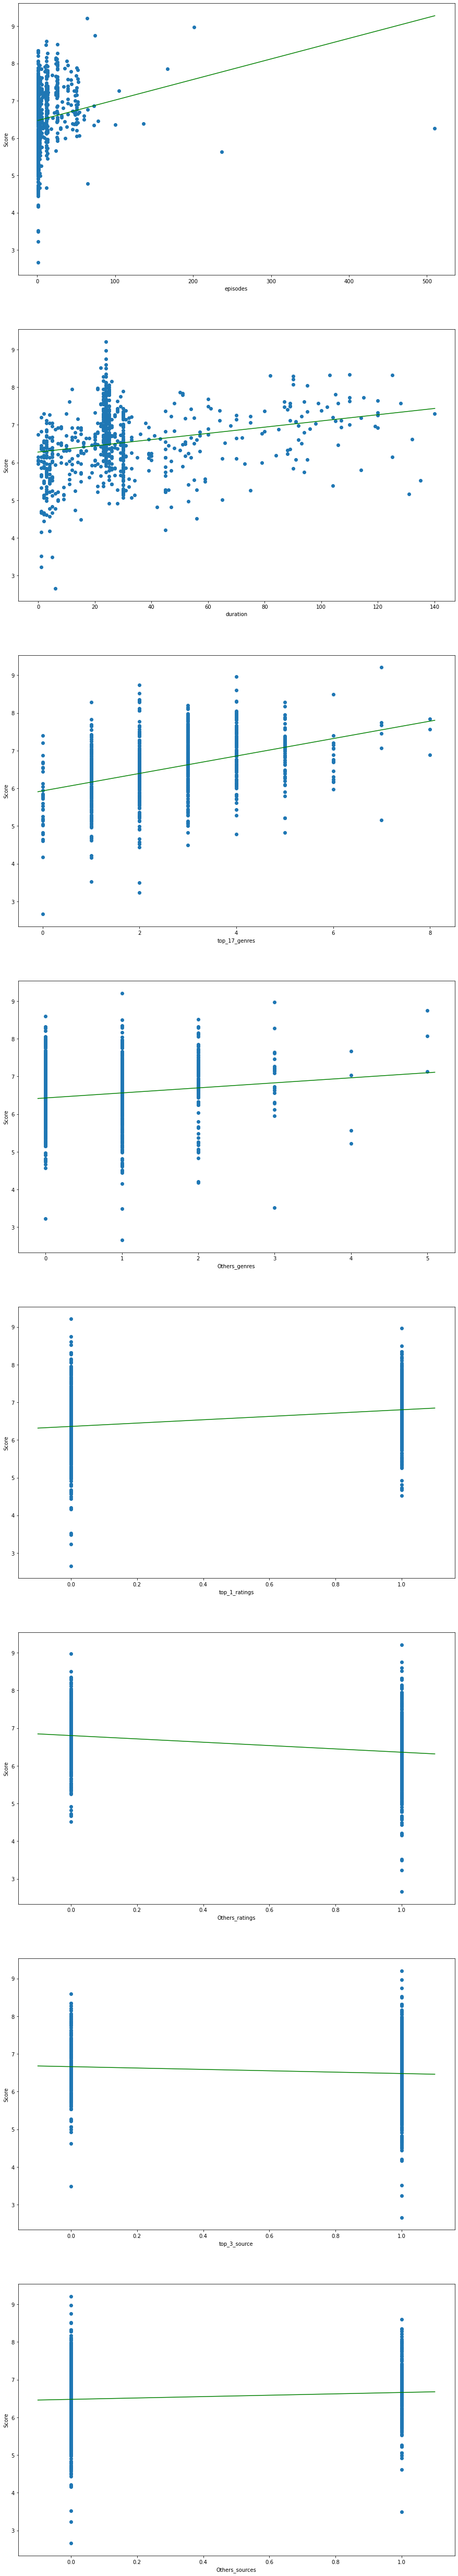

In [21]:
#Mo hinh hoa du lieu bang cach chon mo hinh toi uu cua 1 gia tri so voi ket qua
fig, axes = plt.subplots(len(funcX_after_change), 1,figsize=(15,90))
for i in range(len(funcX_after_change)):
    model_best = LinearRegression()
    model_best.fit(after_drop_col_X_train[:,i].reshape(-1,1),y_train)
    axes[i].scatter(after_drop_col_X_train[:,i],y_train)
    axes[i].set_xlabel(f'{funcX_after_change[i]}')
    axes[i].set_ylabel('Score')

    min_x = after_drop_col_X_train[:,i].min() - 0.1
    max_x = after_drop_col_X_train[:,i].max() + 0.1
    axes[i].plot([min_x, max_x], model_best.predict(np.array([[min_x], [max_x]])), color='g');

Mô hình hoá độ lỗi của tập train, validation dựa trên từng giá trị của top genres, top rating và top source được đưa vào

Text(0.5, 1.0, 'val_rr')

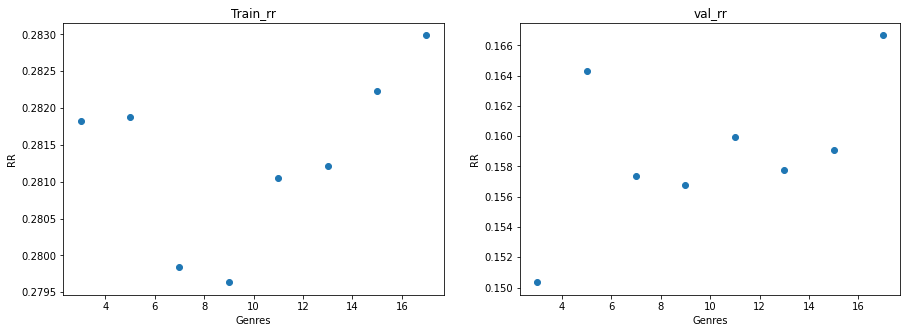

In [22]:
#Mo hinh hoa do loi cua tạp du lieu dua tren genres
train_rr_df = data=np.array(train_rr).reshape(len(top_), len(top_rating_), -1)            
val_rr_df = data=np.array(val_rr).reshape(len(top_), len(top_rating_), -1)
fig, axes = plt.subplots(1, 2,figsize=(15,5))
axes[0].scatter(top_,train_rr_df[:,0,0])
axes[0].set_xlabel('Genres')
axes[0].set_ylabel('RR')
axes[0].set_title('Train_rr')
axes[1].scatter(top_,val_rr_df[:,0,0])
axes[1].set_xlabel('Genres')
axes[1].set_ylabel('RR')
axes[1].set_title('val_rr')

Text(0.5, 1.0, 'val_rr')

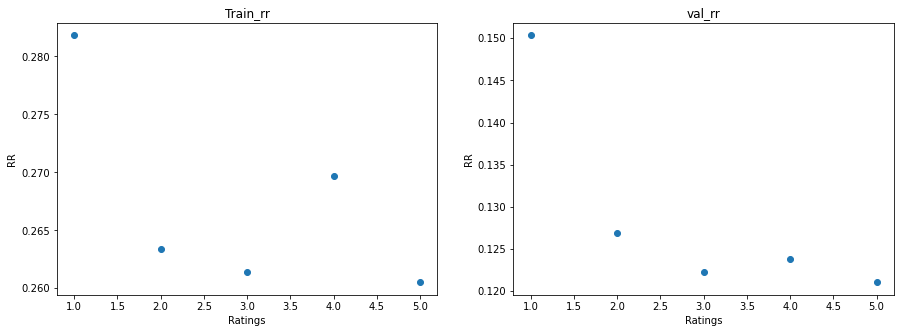

In [23]:
#Mo hinh hoa do loi cua tạp du lieu dua tren rating
fig, axes = plt.subplots(1, 2,figsize=(15,5))
axes[0].scatter(top_rating_,train_rr_df[0,:,0])
axes[0].set_xlabel('Ratings')
axes[0].set_ylabel('RR')
axes[0].set_title('Train_rr')
axes[1].scatter(top_rating_,val_rr_df[0,:,0])
axes[1].set_xlabel('Ratings')
axes[1].set_ylabel('RR')
axes[1].set_title('val_rr')

Text(0.5, 1.0, 'val_rr')

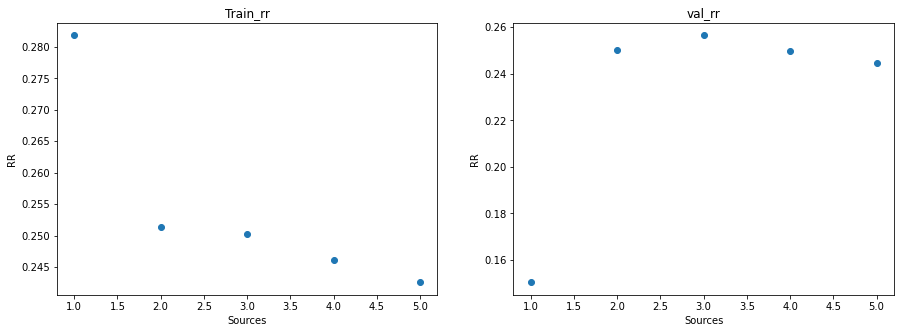

In [24]:
#Mo hinh hoa do loi cua tạp du lieu dua tren source
fig, axes = plt.subplots(1, 2,figsize=(15,5))
axes[0].scatter(top_source_,train_rr_df[0,0,:])
axes[0].set_xlabel('Sources')
axes[0].set_ylabel('RR')
axes[0].set_title('Train_rr')
axes[1].scatter(top_source_,val_rr_df[0,0,:])
axes[1].set_xlabel('Sources')
axes[1].set_ylabel('RR')
axes[1].set_title('val_rr')

# Tìm công thức cuối cùng

In [25]:
#Huan luyen mo hinh cuoi cung
full_pipeline.set_params(prep__col_trans__trans__cohe1__num_top_ = best_top_, 
                        prep__col_trans__trans__cohe2__num_top_rating_ = best_top_rating_, prep__col_trans__trans__cohe2__num_top_source_ = best_top_source_)
full_pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 Pipeline(steps=[('col_trans',
                                  ColumnTransformer(transformers=[('trans',
                                                                   Pipeline(steps=[('drop1',
                                                                                    colDrop()),
                                                                                   ('cohe1',
                                                                                    customOneHotEncoder_1(num_top_=17)),
                                                                                   ('cohe2',
                                                                                    customOneHotEncoder_2(num_top_source_=3))]),
                                                                   Index(['genres', 'rating', 'source', 'episodes', 'duration', 'producers',
       'studios', 'favorites', 'scored_by'],
      dtype='object'))])),
                                 ('imputer', SimpleImputer())])),
                ('lnr', LinearRegression())])

In [26]:
#Tim w0 va w1-wn
coef = full_pipeline.named_steps['lnr'].coef_
intercept = full_pipeline.named_steps['lnr'].intercept_
print(coef)
print(intercept)

[ 0.00430458  0.00644003  0.16801104  0.11221331  0.15195123 -0.15195123
 -0.10555638  0.10555638]
5.853383118388506


In [27]:
#Tim ra cong thuc output duoc tinh theo input tu cong thuc nao
final_fomula = 'y = ' + f'{intercept}'
for i in range(len(coef)):
    final_fomula += ' + ' + f'{coef[i].round(5)}' + '*' + '(' +  funcX_after_change[i] + ')'
final_fomula

'y = 5.853383118388506 + 0.0043*(episodes) + 0.00644*(duration) + 0.16801*(top_17_genres) + 0.11221*(Others_genres) + 0.15195*(top_1_ratings) + -0.15195*(Others_ratings) + -0.10556*(top_3_source) + 0.10556*(Others_sources)'

In [28]:
#Kiem tra do loi r^2 tren tap test
baseline_preds = y_train.mean()
rr = compute_rr(y_test, full_pipeline.predict(X_test), baseline_preds) 
print('Độ đo r^2 trên tập kiểm tra là ' + f'{rr:.3f}')

Độ đo r^2 trên tập kiểm tra là 0.340


Kết thúc đồ án.